# DL Tutorial 2: Diffusion Models for Galaxy Generation

This notebook trains a simple diffusion model to generate galaxy images from the same Galaxy Zoo thumbnails used in the classification tutorial.

We ignore labels entirely and focus on unconditional image generation.

### Open In Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Road2SKA/DL_Basics_tutorial/blob/main/this_galaxy_does_not_exist.ipynb)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torchsummary import summary

from PIL import Image
import time
import os
import subprocess

from google.colab import output
output.enable_custom_widget_manager()

%pylab inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Populating the interactive namespace from numpy and matplotlib


## 1. Download Galaxy Zoo thumbnails

We reuse the same galaxy thumbnails as in the classification tutorial. Labels are ignored for diffusion training.

In [2]:
# Download the dataset (same as classification notebook)
!wget -q https://raw.githubusercontent.com/MichelleLochner/ml-tutorials/main/data/galaxy_zoo.zip
!unzip -q galaxy_zoo.zip -d galaxy_zoo
!ls -orth

total 79M
drwxr-xr-x 1 root 4.0K Dec  9 14:42 sample_data
-rw-r--r-- 1 root  79M Feb  2 07:34 galaxy_zoo.zip
drwxr-xr-x 3 root 4.0K Feb  2 07:34 galaxy_zoo


## 2. Dataset and preprocessing

We ignore labels and simply load all images from both train/test folders.
Images are resized to $64\times64$ and normalized to $[-1,1]$.

In [3]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 64  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 50
    save_model_epochs = 50
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-galaxies"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    hub_private_repo = None
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

In [4]:
image_size = config.image_size # Ensure preprocess uses the image size from config
preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

class ThumbnailsDataset(Dataset):
    def __init__(self, root_dir, transform=None, device=None, maxsize=None):
        """
        Dataset that loads all images once and preloads them to GPU memory.

        Parameters
        ----------
        root_dir : str
            Root directory. Each subfolder = one class.
        transform : torchvision.transforms, optional
            Transforms to apply (must output a Tensor).
        device : torch.device or str, optional
            Device where data will be stored. Default: 'cuda' if available.
        """
        self.transform = transform
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {c: i for i, c in enumerate(classes)}

        self.images = []
        self.targets = []
        self.names = []

        print(f"🔄 Preloading dataset to {self.device}...")

        for c in classes:
            class_dir = os.path.join(root_dir, c)
            files = [f for f in os.listdir(class_dir) if f.lower().endswith(".png")]
            if maxsize is not None:
              files = files[:maxsize]

            for f in files:
                path = os.path.join(class_dir, f)
                im_name = os.path.splitext(f)[0]

                image = Image.open(path).convert("RGB")

                if self.transform:
                    image = self.transform(image)  # Must produce a tensor

                if not torch.is_tensor(image):
                    raise TypeError("Transform must convert images to torch.Tensor")

                # Move to GPU NOW
                image = image.to(self.device, non_blocking=True)

                self.images.append(image)
                self.targets.append(self.class_to_idx[c])
                self.names.append(im_name)

        self.targets = torch.tensor(self.targets, device=self.device)

        print(f"✅ Loaded {len(self.images)} images.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return {
            "image": self.images[idx],     # Already on GPU
            "name": self.names[idx],
            "class": self.targets[idx]     # Already on GPU
        }

In [5]:
training_dataset = ThumbnailsDataset("galaxy_zoo/galaxy_zoo/training", transform=preprocess, maxsize=None)
test_dataset = ThumbnailsDataset("galaxy_zoo/galaxy_zoo/test", transform=preprocess)

🔄 Preloading dataset to cuda...
✅ Loaded 800 images.
🔄 Preloading dataset to cuda...
✅ Loaded 200 images.


In [6]:
def plot_galaxy(dataset, idx):
    """
    Convenience function to make a nice image of a particular galaxy
    """
    # Retrieve the image
    im = dataset[idx]['image'].cpu().detach()
    # For whatever reason, torch and matplotlib expect different orders of the channels so we need to permute them
    im = im.permute(1, 2, 0)
    # Show the image
    imshow(im)
    
    # Get the class and put it in a title
    target = dataset[idx]['class']
    if target == 0:
        img_class = 'elliptical'
    else:
        img_class = 'spiral'
    xticks([])
    yticks([])
    title(img_class)

In [7]:
training_dataloader = DataLoader(training_dataset, batch_size=config.train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=True)

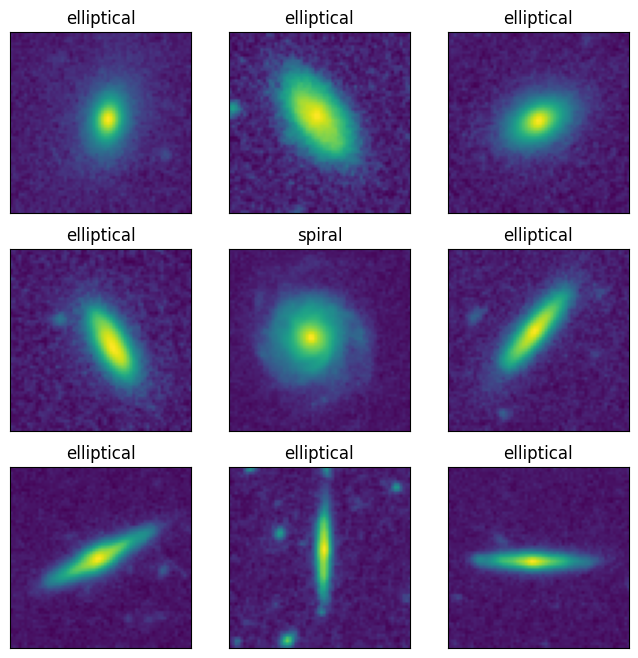

In [8]:
# Pick some random examples
inds = np.random.choice(np.arange(len(training_dataset)), 9, replace=False)

figure(figsize=(8,8))
for i in range(9):
    subplot(3,3,i+1)
    idx = inds[i]
    plot_galaxy(training_dataset, idx)

## 3. Diffusion model setup

We implement a lightweight DDPM-style model (UNet + noise schedule).
This is intentionally compact for tutorial purposes.

In [9]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images, 1 for Grayscale
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 64, 128, 128, 256, 256),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
).to(device)

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [10]:
sample_image = training_dataset[0]["image"].unsqueeze(0)
print("Input shape:", sample_image.shape)

print("Output shape:", model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 1, 64, 64])
Output shape: torch.Size([1, 1, 64, 64])


In [15]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

noise = torch.randn(sample_image.shape).to(device)

timesteps = torch.LongTensor([50]).to(device)

noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)
print(sample_image.shape, noise.shape, noisy_image.shape)
#Image.fromarray(((noisy_image.cpu().permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])


## 4. Training

Tip: if you are on CPU, reduce `epochs`, `timesteps`, or `image_size`.

In [16]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample

loss = F.mse_loss(noise_pred, noise)

In [17]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

lr_scheduler = get_cosine_schedule_with_warmup(

    optimizer=optimizer,

    num_warmup_steps=config.lr_warmup_steps,

    num_training_steps=(len(training_dataloader) * config.num_epochs),

)

In [18]:
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid

def evaluate(config, epoch, pipeline):

    # Sample some images from random noise (this is the backward diffusion process).

    # The default pipeline output type is `List[PIL.Image]`

    images = pipeline(

        batch_size=config.eval_batch_size,

        generator=torch.Generator(device='cpu').manual_seed(config.seed), # Use a separate torch generator to avoid rewinding the random state of the main training loop

    ).images

    # Convert PIL Images to PyTorch Tensors and stack them
    # The images are already in 0-255 range and RGB, so ToTensor will normalize to 0-1 and change shape to (C, H, W)
    to_tensor = transforms.ToTensor()
    stacked_images = torch.stack([to_tensor(img) for img in images])

    # Define the directory to save the stacked images
    output_dir = os.path.join(config.output_dir, "stacked_samples")
    os.makedirs(output_dir, exist_ok=True)

    # Save the stacked tensor
    torch.save(stacked_images, f"{output_dir}/{epoch:04d}.pt")

    # Optionally, you can still save a grid for visual inspection if needed, or remove this part.
    # For this request, we prioritize saving the stacked array.
    #image_grid = make_image_grid(images, rows=4, cols=4)
    #test_dir = os.path.join(config.output_dir, "samples")
    #os.makedirs(test_dir, exist_ok=True)
    #image_grid.save(f"{test_dir}/{epoch:04d}.png")
    

In [19]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name, exist_ok=True
            ).repo_id
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["image"]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if False : #(epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

In [20]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, training_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

## 5. Sampling (image generation)

We now sample new galaxies from pure noise using the trained model.

In [ ]:
!ls ddpm-galaxies/stacked_samples/0049.pt

0049.pt


In [24]:
# load the stacked tensor
stacked_images = torch.load("ddpm-galaxies/stacked_samples/0049.pt")
print("Shape of stacked images tensor:", stacked_images.shape)

Shape of stacked images tensor: torch.Size([16, 1, 64, 64])


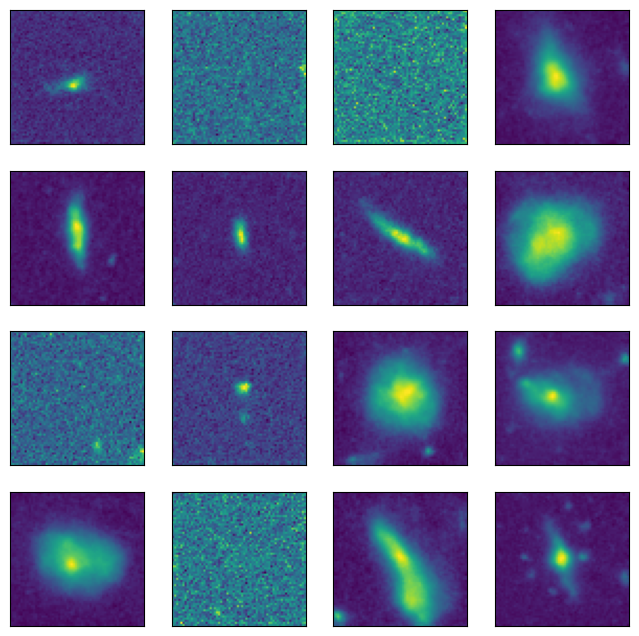

In [25]:
# imshow the 16 of them on q 4x4 layer layout
figure(figsize=(8,8))
for i in range(16):
    subplot(4,4,i+1)
    im = stacked_images[i].permute(1, 2, 0)
    imshow(im)
    xticks([])
    yticks([])